In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load dataset from Google drive

In [3]:
matrix_2d  = xr.open_dataarray("path/samples_200_Dummy.nc")
matrix_1d = matrix_2d.stack(z=("nodes","DoFs"))

matrix1  = xr.open_dataarray("path/samples_200_Dummy.nc") 
sims_a,times, DoFs, node_ID = matrix_2d.indexes.values()

matrix_conv1d = (matrix_1d) / np.max(matrix_1d) ## normalise the dataset by dividing max value
matrix_conv2d = (matrix_2d) / np.max(matrix_2d) ## normalise the dataset by dividing max value


### INPUT FEM PARAMETERS
inputParameter = pd.read_csv("/content/drive/MyDrive/Inputs_data_200.csv") ## input fem parameters
input_fem =  inputParameter.iloc[:,0:4]

In [5]:
import yaml

with open(r'path/data.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    inputParameter = yaml.load(file)
    initial = inputParameter['initialise']
    Autoencoder_paramters = inputParameter['Autoencoder_paramters']

    print(initial,Autoencoder_paramters)

{'DOF': 3, 'nodes': 7441, 'time_states': 32, 'split_size': 0.2, 'simulation': 50} {'latent': 8, 'lr': 0.0001, 'epoch': 1000, 'batchsize': 7, 'architecture': 4, 'model': 'conv1d', 'kernal': 3, 'padding': 'valid', 'activation': 'relu', 'convolution_layer1': 1500, 'convolution_layer2': 750, 'convolution_layer3': 375, 'convolution_layer4': 150, 'convolution_layer5': 0}


In [6]:
input_matrix_1D = initial['time_states'],initial['nodes']*initial['DOF']

In [7]:
if Autoencoder_paramters['architecture'] == 1 :  ## if nodes <100 
        conv1,conv2,conv3,conv4,conv5 = Autoencoder_paramters['convolution_layer1'],Autoencoder_paramters['convolution_layer2'],Autoencoder_paramters['convolution_layer3'],Autoencoder_paramters['convolution_layer4'],Autoencoder_paramters                                                                                ['convolution_layer5']
        print(conv1,conv2,conv3,conv4,conv5)

elif Autoencoder_paramters['architecture'] ==2 or 4:     ## if nodes greater than 1000 and less than 3000
        conv1,conv2,conv3,conv4,conv5 = Autoencoder_paramters['convolution_layer1'],Autoencoder_paramters['convolution_layer2'],Autoencoder_paramters['convolution_layer3'],Autoencoder_paramters['convolution_layer4'],Autoencoder_paramters                                                                                ['convolution_layer5']
                                            
        print(conv1,conv2,conv3,conv4,conv5)

elif Autoencoder_paramters['architecture']==3 or 5:       ## if nodes greater than 3000 and less than 5000
        conv1,conv2,conv3,conv4,conv5 = Autoencoder_paramters['convolution_layer1'],Autoencoder_paramters['convolution_layer2'],Autoencoder_paramters['convolution_layer3'],Autoencoder_paramters['convolution_layer4'],Autoencoder_paramters                                                                                ['convolution_layer5']
        print(conv1,conv2,conv3,conv4,conv5)

1500 750 375 150 0


In [8]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
from sklearn.model_selection import train_test_split

## SPLIT THE AUTOENCODER DATASET FOR TRAINIG AND TESTING

class Traintestsplit_AE:
    
    
    """
    X - Input FEM parameters
    Y1 - convolutional 1d matrix
    Y2 - convolutional 2d matrix
    model - either convolutional 1d or 2d
    Returns: train_test split for selected model

    """
    def __init__(self,inp,conv1d,conv2d,model,simulation,nodes,split_size):
        #super(Traintestsplit_AE, self).__init__()
        self.inp  = inp
        self.conv1d = conv1d
        self.conv2d = conv2d
        self.model = model
        self.simulation = simulation
        self.nodes = nodes
        self.split_size = split_size
        #self.samples = self.simulation*(1-self.split_size)
        
    def call(self):                
        if self.model == 'conv1d':                      # if model is convolutional 1d
            Y1 =self.conv1d                      ## DISPLACEMENT MATRIX FOR CONV 1D
            
                        
            X_train, X_test, Y_train, Y_test = train_test_split(self.inp,Y1,random_state=42,
                                                                 test_size=self.split_size,shuffle = True)
            
            X_train = X_train.iloc[:int((self.simulation)*(1-self.split_size)),:]
            X_test  = X_test.iloc[:int((self.simulation)*(self.split_size)),:]
            Y_train = Y_train[:int((self.simulation)*(1-self.split_size)),:,:self.nodes*3]
            Y_test  = Y_test[:int((self.simulation)*(self.split_size)),:,:self.nodes*3]
            
            return X_train,X_test,Y_train,Y_test


        elif self.model =='conv2d':                            # else model is convolutional 2d
            Y2 = self.conv2d                                   ## DISPLACEMENT MATRIX FOR CONV 2D  
            
            X_train, X_test, Y_train, Y_test = train_test_split(self.inp,Y2,random_state=42,
                                                                 test_size=0.20,shuffle = True)

            X_train = X_train.iloc[:int((self.simulation)*(1-self.split_size)),:]
            X_test  = X_test.iloc[:int((self.simulation)*(self.split_size)),:]
            Y_train  = Y_train[:int((self.simulation)*(1-self.split_size)),:,:self.nodes*3,:]
            Y_test  = Y_test[:int((self.simulation)*(self.split_size)),:,:self.nodes*3,:] 

            return X_train,X_test,Y_train,Y_test


In [9]:
X = Traintestsplit_AE(input_fem,matrix_conv1d ,matrix_conv2d,Autoencoder_paramters['model'],
             initial['simulation'],initial['nodes'],initial['split_size'])
                                                                

X_train,X_test,Y_train,Y_test = X.call()
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((40, 4), (10, 4), (40, 32, 22323), (10, 32, 22323))

## LOAD THE AUTOENCODER MODEL

In [10]:
import tensorflow as tf
# Check its architecture
saved_model_AE = tf.keras.models.load_model('path/model1_LT{}_nds{}_batch{}_sim{}_conv1{}_epoch{}'.format(Autoencoder_paramters['latent'],
    initial['nodes'],Autoencoder_paramters['batchsize'],initial['simulation'],conv1,Autoencoder_paramters['epoch']))

saved_model_AE.summary()


#Evaluating the Model using the Test Set

Y_test = np.array(Y_test)
test_loss, test_acc = saved_model_AE.evaluate(Y_test,  Y_test, verbose=1)
print(Y_test.shape)
print('\nTest accuracy:', test_acc)

Model: "conv_autoencoder_1d_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 8)                 104848583 
_________________________________________________________________
sequential_9 (Sequential)    (None, 32, 22323)         104871348 
Total params: 209,719,931
Trainable params: 209,719,931
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 28s 28s/step - loss: 5.5604e-05 - accuracy: 0.4906
(10, 32, 22323)

Test accuracy: 0.4906249940395355


In [11]:
saved_model_AE.encoder.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 30, 1500)          100455000 
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 28, 750)           3375750   
_________________________________________________________________
average_pooling1d_7 (Average (None, 14, 750)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 12, 375)           844125    
_________________________________________________________________
average_pooling1d_8 (Average (None, 6, 375)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 4, 150)            168900    
_________________________________________________________________
flatten_4 (Flatten)          (None, 600)              

In [12]:
saved_model_AE.decoder.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 600)               5400      
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 150)            0         
_________________________________________________________________
conv1d_transpose_15 (Conv1DT (None, 6, 375)            169125    
_________________________________________________________________
up_sampling1d_7 (UpSampling1 (None, 12, 375)           0         
_________________________________________________________________
conv1d_transpose_16 (Conv1DT (None, 14, 750)           844500    
_________________________________________________________________
up_sampling1d_8 (UpSampling1 (None, 28, 750)           0         
_________________________________________________________________
conv1d_transpose_17 (Conv1DT (None, 30, 1500)         

In [13]:
## predict the test data and then decode 
#decoded = saved_model_AE.predict(Y_test)
latent_test = saved_model_AE.encoder.predict(Y_test)
latent_train = saved_model_AE.encoder.predict(Y_train)### This is for training with FEM parameters

In [14]:
decoded = saved_model_AE.decoder.predict(latent_train)

## DATASET FOR REGRESSION MODEL

x datasets are the FEM Parameters and y datasets are the latent space from autoencoder

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
import timeit
from tensorflow.keras import layers, losses

## Feed forward neural networks

def build_FFNN(c1,c2,c3,c4,c5,latent,n_hidden):

    """
    c1 - number of neurons in first hidden layer
    ...
    c5 - number of neuron in second hidden layer
    latent - low dimensional space
    Returns: latent vector

    """
# We define ADAM as an optimizer
    #opt = keras.optimizers.Adam(learning_rate=lr)
    if n_hidden ==3:
        model = tf.keras.Sequential([
            Dense(c1,input_dim=4,activation ='relu'),
            Dense(c2,activation ='relu'),
            Dense(c3,activation ='relu'),
            Dense(latent)])
    elif n_hidden == 2:
        model = tf.keras.Sequential([
            Dense(c1,input_dim=4,activation ='relu'),
            Dense(c2,activation ='relu'),
            Dense(latent)])
    elif n_hidden ==4:
        model = tf.keras.Sequential([
            Dense(c1,input_dim=4,activation ='relu'),
            Dense(c2,activation ='relu'),
            Dense(c3,activation ='relu'),
            Dense(c4,activation ='relu'),
            Dense(latent)])
    elif n_hidden ==5:
        model = tf.keras.Sequential([
            Dense(c1,input_dim=4,activation ='relu'),
            Dense(c2,activation ='relu'),
            Dense(c3,activation ='relu'),
            Dense(c4,activation ='relu'),
            Dense(c5,activation ='relu'),
            Dense(latent)])
        
    return model

In [22]:
def split_regression(X_train,latent_train):
    
    
    """
    X_train - Input FEM parameters
    latent_train - targets
    Returns: train_validation split for regression

    """
    x_train, x_val, y_train, y_val = train_test_split(X_train,latent_train,random_state=42,
                                                                 test_size=0.20,shuffle = True)
    
    return x_train, x_val, y_train, y_val

In [23]:

x_train, x_val, y_train, y_val = split_regression(X_train,latent_train)

x_train.shape,y_train.shape,x_val.shape,y_val.shape



((32, 4), (32, 8), (8, 4), (8, 8))

## FEED FORWARD NEURAL NETWORKS

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
import timeit
from tensorflow.keras import layers, losses

In [25]:
n_hidden = 2                  
c1,c2,c3,c4,c5 = 64,64,64,64,0      
model_FFNN = build_FFNN(c1,c2,c3,c4,c5,Autoencoder_paramters['latent'],n_hidden)


In [26]:
# Train the model, iterating on the data in batches of 7 samples

from keras import optimizers
from tensorflow.keras import layers, losses

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_FFNN.compile(optimizer=opt, loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy'])
start_time = timeit.default_timer()
history = model_FFNN.fit(x_train, y_train, epochs=10000,
                         batch_size = 10,shuffle ='True',
                    verbose=False,validation_data = (x_val,y_val) )
elapsed = timeit.default_timer() - start_time

In [27]:
model_FFNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
Total params: 5,000
Trainable params: 5,000
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Print the time taken to train and the final result on the test set
print("Time (s): ", elapsed)
print("End MAE: ", model_FFNN.evaluate(X_test, latent_test))

Time (s):  309.39132939800004
1/1 [==============================] - 0s 19ms/step - loss: 0.0874 - accuracy: 1.0000
End MAE:  [0.0874149277806282, 1.0]


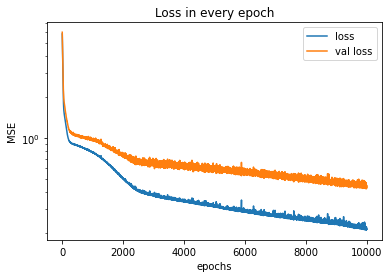

In [29]:
#We plot for comparison the MSE during learning in the two cases
plt.semilogy(np.sqrt(history.history['loss']), label='loss')

plt.semilogy(np.sqrt(history.history['val_loss']), label='val loss')

plt.title('Loss in every epoch')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend()

In [36]:
## Predict the test sample (project the latent space from FFNN to convolutional decoder)

latent_predict_FFNN = model_FFNN.predict(X_test)

decoded_predict_FFNN = saved_model_AE.decoder.predict(latent_predict_FFNN)
decoded_predict_FFNN = decoded_predict_FFNN * (np.max(matrix_1d).values)


In [37]:
## convert 4d matrix to 3d for conv2d 

test_data = (np.array(Y_test)) *np.max(matrix_1d).values

In [33]:
## convert matrix 3d to 4d for plots
if Autoencoder_paramters['model'] =='conv1d':
    test_data_plots = np.array(Y_test).reshape(Y_test.shape[0],Y_test.shape[1],
                                                      initial['nodes'],3) *(np.max(matrix_1d).values)
    decoded_predict = np.array(decoded_predict_FFNN).reshape(decoded_predict_FFNN.shape[0],
                              decoded_predict_FFNN.shape[1],initial['nodes'],3) 


In [34]:
sims, states, DoFs, nodes = matrix_2d.indexes.values()
test_idx = np.array(X_test.index)
node_idx = np.array(nodes[0:initial['nodes']])

test_pred_FFNN = xr.DataArray(decoded_predict, dims = ["t_sims","t_states","Nds","DoFs"],
                         coords = {"t_sims":test_idx,                              
                                   "Nds": node_idx,
                                   "DoFs": DoFs})


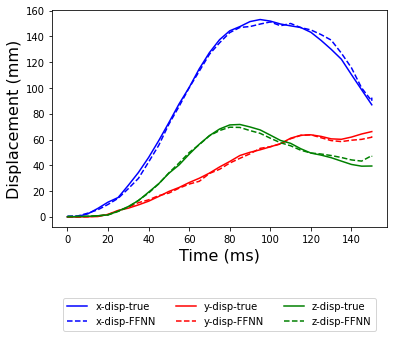

In [35]:
plt.figure()
Nnodeno = 1001983

plt.plot(states, matrix_2d.sel(sims = test_idx[-7], nodes = Nnodeno, DoFs = 'x_disp'),'b',label='x-disp-true')
plt.plot(states, test_pred_FFNN.sel(t_sims = test_idx[-7], Nds = Nnodeno, DoFs = 'x_disp'),'--b',label='x-disp-FFNN')

plt.plot(states, matrix_2d.sel(sims = test_idx[-7], nodes = Nnodeno, DoFs = 'y_disp'),'r',label='y-disp-true')
plt.plot(states, test_pred_FFNN.sel(t_sims = test_idx[-7], Nds = Nnodeno, DoFs = 'y_disp'),'--r',label='y-disp-FFNN')

plt.plot(states, matrix_2d.sel(sims = test_idx[-7], nodes = Nnodeno, DoFs = 'z_disp'),'g',label='z-disp-true')
plt.plot(states, test_pred_FFNN.sel(t_sims = test_idx[-7], Nds = Nnodeno, DoFs = 'z_disp'),'--g',label='z-disp-FFNN')

#plt.title('Test sample 1-  Node no :1000001')
plt.xlabel('Time (ms)', fontsize = 16)
plt.ylabel('Displacement (mm)', fontsize = 16)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5), ncol=3)

## Mean distance error for autoencoder

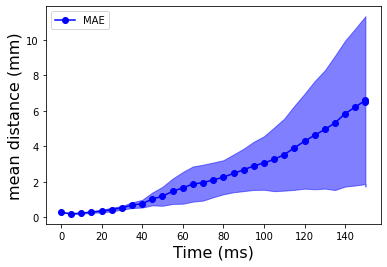

In [40]:
mean_dist_nds_test = []
mean_mae_nds_test = []
for j in range(0,X_test.shape[0]):
    dist_nds = []
    mae_nds = []
    pred = decoded_predict_FFNN[j,:,:].reshape(len(times),3,initial['nodes'])
    # pred = np.array(pred_lst)[j,:,:].reshape(len(times_a),3,no_Nodes)
    true = test_data[j,:,:].reshape(len(times),3,initial['nodes'])
    for k in range(initial['nodes']):
        squared_dist = np.sum((true[:,:,k]-pred[:,:,k])**2, axis=1)
        dist = np.sqrt(squared_dist)
        dist_nds.append(dist)
        mae_t = np.mean(abs(true[:,:,k]- pred[:,:,k]), axis=1)
        mae_nds.append(mae_t)
    mean_dist_nds = np.array(dist_nds).mean(axis = 0)
    mean_dist_nds_test.append(mean_dist_nds)
    mean_mae_nds = np.array(mae_nds).mean(axis = 0)
    mean_mae_nds_test.append(mean_mae_nds)

mean_dist_mean = np.array(mean_dist_nds_test).mean(axis=0)
mean_dist_std = np.array(mean_dist_nds_test).std(axis=0)
mean_mae_mean = np.array(mean_mae_nds_test).mean(axis=0)
mean_mae_std = np.array(mean_mae_nds_test).std(axis=0)

mean_dist_mean = np.array(mean_dist_nds_test).mean(axis=0)
mean_dist_std = np.array(mean_dist_nds_test).std(axis=0)
mean_mae_mean = np.array(mean_mae_nds_test).mean(axis=0)
mean_mae_std = np.array(mean_mae_nds_test).std(axis=0)

plt.figure()
plt.xlabel('Time (ms)', fontsize = 16)
plt.ylabel('mean distance (mm)', fontsize = 16)
plt.plot(times,mean_mae_mean,'o-', color = "b", label= "MAE")
plt.fill_between(times, mean_mae_mean-mean_mae_std, mean_mae_mean+mean_mae_std,color = "b",alpha =0.5)
plt.legend(loc='upper left')

In [42]:
## Mean absolute error

from sklearn.metrics import mean_absolute_error
mae = []
decoded = decoded*np.max(matrix_1d).values
for j in range(0,X_test.shape[0]):
    MAE =  mean_absolute_error(test_data[j,:,:], decoded_predict_FFNN[j,:,:])#,multioutput='raw_values')
    mae.append(MAE)
print(mae)

[2.6869192811263263, 3.6679831671835372, 2.394366122647856, 1.3722940541582498, 3.7461038343261905, 1.3875934315849376, 6.099317185112285, 1.428333391662301, 1.9024184157251187, 1.3748536217268503]


In [ ]:
# Euclidean distance error

euclidean_error = mean_Ecd_dist_sim

## visualization of each and every layer in encoder


In [46]:
successive_outputs_encoder = [layer.output for layer in saved_model_AE.encoder.layers[:]]


inputs = tf.keras.layers.Input(shape=(initial['time_states'],initial['nodes']*initial['DOF']))
visualization_model_encoder = tf.keras.models.Model(inputs =saved_model_AE.encoder.input, outputs = successive_outputs_encoder)
visualization_model_encoder.summary(),inputs.shape

x   = np.array(Y_test)

successive_feature_maps = visualization_model_encoder.predict(x)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 22323)]       0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 30, 1500)          100455000 
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 28, 750)           3375750   
_________________________________________________________________
average_pooling1d_7 (Average (None, 14, 750)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 12, 375)           844125    
_________________________________________________________________
average_pooling1d_8 (Average (None, 6, 375)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 4, 150)            1689

In [47]:
input = Y_test

conv1 = successive_feature_maps[-8]
conv2 = successive_feature_maps[-7]
pool1 = successive_feature_maps[-6]
conv3 = successive_feature_maps[-5]
pool2 = successive_feature_maps[-4]
conv4 = successive_feature_maps[-3]
Flatten = successive_feature_maps[-2]
dense = successive_feature_maps[-1]

input.shape

(10, 32, 22323)

 ...]

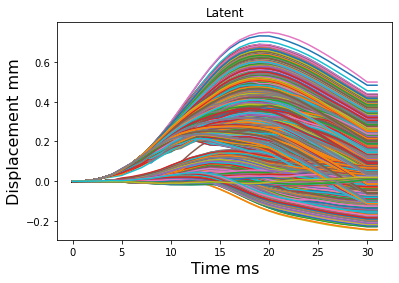

In [48]:
## Visualize the displacement matrix for first 1000 nodes
sim_num = 0
plt.figure()
plt.title('Latent')
plt.xlabel('Time ms', fontsize = 16)
plt.ylabel('Displacement mm', fontsize = 16)
plt.plot(input[sim_num,:,0:3000],'-',label='Input displacement')  

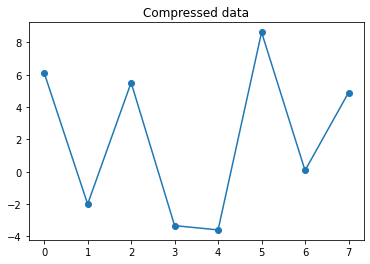

In [49]:
# Visulise the latent space
plt.figure()
plt.title('Compressed data')
plt.plot(dense[0,:],'o-',label='Latent visualisation')  



## visualization of each and every layer in decoder


In [50]:
successive_outputs_decoder = [layer.output for layer in saved_model_AE.decoder.layers[:]]


visualization_model = tf.keras.models.Model(inputs =saved_model_AE.decoder.input, outputs = successive_outputs_decoder)
visualization_model.summary(),inputs.shape

latent   = np.array(dense)

feature_maps_decoder = visualization_model.predict(latent)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9_input (InputLayer)   [(None, 8)]               0         
_________________________________________________________________
dense_9 (Dense)              (None, 600)               5400      
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 150)            0         
_________________________________________________________________
conv1d_transpose_15 (Conv1DT (None, 6, 375)            169125    
_________________________________________________________________
up_sampling1d_7 (UpSampling1 (None, 12, 375)           0         
_________________________________________________________________
conv1d_transpose_16 (Conv1DT (None, 14, 750)           844500    
_________________________________________________________________
up_sampling1d_8 (UpSampling1 (None, 28, 750)           0   

In [51]:
deconvolution_layer4 = feature_maps_decoder[-1]
deconvolution_layer3 = feature_maps_decoder[-2]
upsampling_layer2 = feature_maps_decoder[-3]
deconvolution_layer2 = feature_maps_decoder[-4]
upsampling_layer1 = feature_maps_decoder[-5]
deconvolution_layer1 = feature_maps_decoder[-6]

 ...]

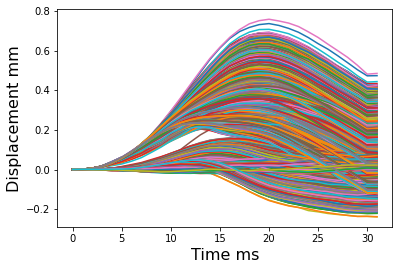

In [53]:
## Visualize the AE-GPR predicted displacements
plt.figure()
plt.xlabel('Time ms', fontsize = 16)
plt.ylabel('Displacement mm', fontsize = 16)
plt.plot(deconvolution_layer4[0,:,0:3000],'-',label='Input displacement')  